# Cat and Dog Classification
Classify images of cats and dogs using Histogram of Oriented Gradients (HOG) for feature extraction and Decision Tree for classification.

In [1]:
import os
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import hog
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from google.colab import files
import zipfile, os

In [ ]:
uploaded = files.upload()
# extract zipfile
with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")

In [24]:
# Load dataset
data_dir = './dataset/dataset'
images, labels = [], []

for file in os.listdir(data_dir):
    if file.endswith('.jpg'):
        img_path = os.path.join(data_dir, file)

        if file.startswith('cat'):
            labels.append(0)  # Cat
        elif file.startswith('dog'):
            labels.append(1)  # Dog
        else:
            continue

        img = imread(img_path)
        img = rgb2gray(img)  # Convert to grayscale
        img_resized = resize(img, (128, 128), anti_aliasing=True)
        images.append(img_resized)

images = np.array(images)
labels = np.array(labels)
print('Images shape:', images.shape)
print('Labels shape:', labels.shape)
print(f'Number of cats: {np.sum(labels == 0)}')
print(f'Number of dogs: {np.sum(labels == 1)}')

Images shape: (615, 128, 128)
Labels shape: (615,)
Number of cats: 260
Number of dogs: 355


In [25]:
def extract_hog_features(images, visualize=False):
    """Extract HOG features from a list of grayscale images."""
    hog_features = []
    hog_images = [] if visualize else None

    for img in images:
        if visualize:
            features, hog_image = hog(
                img,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                block_norm='L2-Hys',
                visualize=True
            )
            hog_features.append(features)
            hog_images.append(hog_image)
        else:
            features = hog(
                img,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                block_norm='L2-Hys',
                visualize=False
            )
            hog_features.append(features)

    hog_features = np.array(hog_features)
    if visualize:
        hog_images = np.array(hog_images)
        return hog_features, hog_images
    else:
        return hog_features, None


In [26]:
def split_and_save_dataset(images, labels, test_size=0.2, train_dir='./dog-cat/train', test_dir='./dog-cat/test'):
    """Split dataset into training and test sets and save images to separate directories."""
    # Stratified split to maintain class balance
    idx_train, idx_test = train_test_split(
        np.arange(len(images)),
        test_size=test_size,
        stratify=labels,
        random_state=42
    )

    X_train = images[idx_train]
    X_test = images[idx_test]
    y_train = labels[idx_train]
    y_test = labels[idx_test]

    # Create directories if not exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Save images
    for i, idx in enumerate(idx_train):
        label = 'cat' if labels[idx] == 0 else 'dog'
        plt.imsave(os.path.join(train_dir, f"{label}.{i}.png"), images[idx], cmap='gray')

    for i, idx in enumerate(idx_test):
        label = 'cat' if labels[idx] == 0 else 'dog'
        plt.imsave(os.path.join(test_dir, f"{label}.{i}.png"), images[idx], cmap='gray')

    # Extract HOG features
    X_train_hog, _ = extract_hog_features(X_train, visualize=False)
    X_test_hog, _ = extract_hog_features(X_test, visualize=False)

    return X_train_hog, X_test_hog, y_train, y_test, idx_train, idx_test


In [27]:
def train_decision_tree(X_train, y_train):
    """Train a Decision Tree classifier on HOG features."""
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    return clf


In [28]:
def evaluate_model(clf, X_test, y_test):
    """Evaluate the Decision Tree classifier on the test set."""
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, y_pred

Test Accuracy: 0.8374


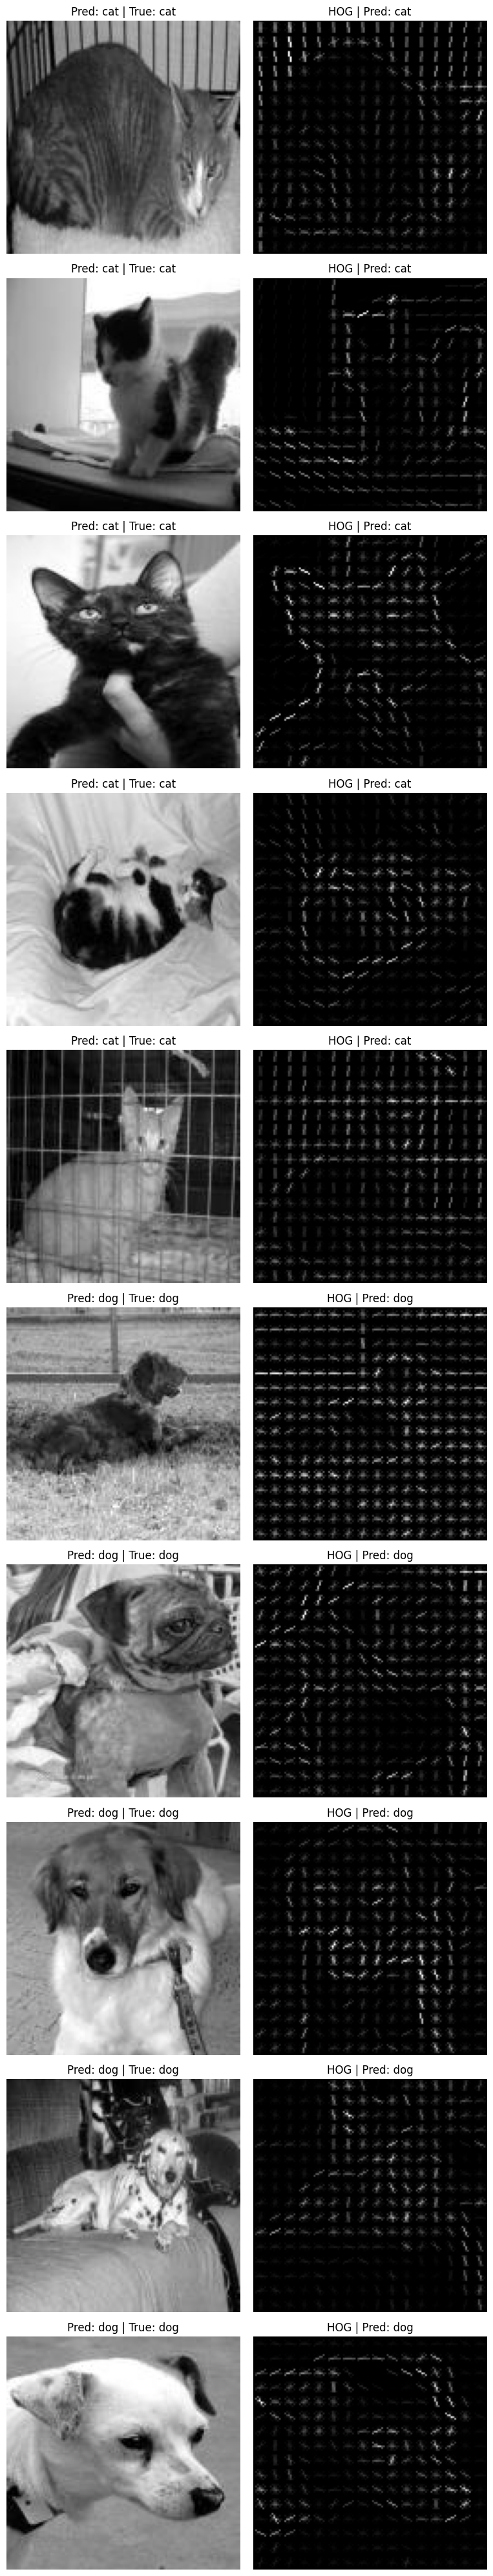

In [29]:
# Extract HOG features
hog_features, hog_images = extract_hog_features(images, visualize=True)

# Split and save dataset
X_train, X_test, y_train, y_test, idx_train, idx_test = split_and_save_dataset(images, labels, test_size=0.2)

# Train Decision Tree
clf = train_decision_tree(X_train, y_train)

# Evaluate model
accuracy, y_pred = evaluate_model(clf, X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Visualize results
classes = ['cat', 'dog']
cat_indices = [idx for idx in idx_test if y_test[np.where(idx_test == idx)[0][0]] == 0]
dog_indices = [idx for idx in idx_test if y_test[np.where(idx_test == idx)[0][0]] == 1]
sample_indices = cat_indices[:min(5, len(cat_indices))] + dog_indices[:min(5, len(dog_indices))]

fig, axes = plt.subplots(len(sample_indices), 2, figsize=(8, 4 * len(sample_indices)))
for i, idx in enumerate(sample_indices):
    ax = axes[i, 0] if len(sample_indices) > 1 else axes[0]
    true_label = y_test[np.where(idx_test == idx)[0][0]]
    pred_label = y_pred[np.where(idx_test == idx)[0][0]]
    ax.imshow(images[idx], cmap='gray')
    ax.set_title(f'Pred: {classes[pred_label]} | True: {classes[true_label]}')
    ax.axis('off')

    ax = axes[i, 1] if len(sample_indices) > 1 else axes[1]
    ax.imshow(hog_images[idx], cmap='gray')
    ax.set_title(f'HOG | Pred: {classes[pred_label]}')
    ax.axis('off')

plt.tight_layout()
plt.show()